In [1]:
import os
import PIL.Image as Image

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.cuda
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

from LookGenerator.datasets.basic_dataset import BasicDataset
from LookGenerator.networks.clothes_feature_extractor import ClothAutoencoder
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.utils import get_num_digits, save_model, load_model
from LookGenerator.networks_training.utils import check_path_and_creat

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [3]:
batch_size_train = 128
batch_size_val = 128
pin_memory = True
num_workers = 8

In [4]:
train_dataset = BasicDataset(
    root_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\train",
    input_dir_name=r"cloth",
    target_dir_name="cloth",
    transform_input=transform_input,
    transform_target=transform_input
)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory,
    num_workers=num_workers
)

In [5]:
val_dataset = BasicDataset(
    root_dir=r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\test",
    input_dir_name="cloth",
    target_dir_name="cloth",
    transform_input=transform_input,
    transform_target=transform_input
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size_train, shuffle=False, pin_memory=pin_memory,
    num_workers=num_workers
)

In [6]:
print(len(val_dataset), len(val_dataloader))
print(len(train_dataset), len(train_dataloader))

2032 16
11647 91


In [7]:
# def _epoch_string(epoch, epoch_num):
#     num_digits_epoch_num = get_num_digits(epoch_num)
#     num_digits_epoch = get_num_digits(epoch)
#
#     epoch_string = "0"*(num_digits_epoch_num - num_digits_epoch) + str(epoch)
#     return epoch_string

In [8]:
# def fit(model, criterion, optimizer, device, train_loader, val_loader, epochs, save_directory, save_step=1):
#
#     train_loss=[]
#     val_loss=[]
#
#     criterion = criterion.to(device)
#     model = model.to(device)
#
#     for epoch in range(epochs):
#         torch.cuda.empty_cache()
#         model.to(device)
#         model.train()
#
#         train_epoch_loss = []
#         for X_batch in tqdm(train_loader):
#             X_batch = X_batch.to(device)
#             optimizer.zero_grad()
#             pred = model(X_batch)
#             #reconstructed, mu, log_var = pred
#             #loss = criterion(X_batch, mu, log_var, reconstructed)
#             loss = criterion(pred, X_batch)
#             loss.backward()
#             optimizer.step()
#             # print(mu, log_var)
#             train_epoch_loss.append(loss.item())
#             # print(loss.item())
#         train_loss.append(np.mean(train_epoch_loss))
#
#         model.eval()
#         val_loss_epoch = []
#         with torch.no_grad():
#           for X_val in tqdm(val_loader):
#               X_val = X_val.to(device)
#               pred = model(X_val)
#               loss = criterion(pred, X_val)
#               #reconstructed, mu, log_var  = pred
#               #loss = criterion(X_val, mu, log_var, reconstructed)
#               val_loss_epoch.append(loss.item())
#         val_loss.append(np.mean(val_loss_epoch))
#
#         print("Epoch [{}/{}], train_loss: {:.3f}, val_loss: {:.3f}".format(
#             epoch+1, epochs,
#             train_loss[-1], val_loss[-1])
#         )
#
#         if (epoch + 1) % save_step == 0:
#             save_model(
#             model.to('cpu'),
#             path=f"{save_directory}\\epoch_{_epoch_string(epoch, epochs)}.pt"
#         )
#
#     return train_loss, val_loss

In [7]:
save_directory=r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\autoDegradation\weights\testClothes_crossEntropy_features_8_16_32_64_128"
check_path_and_creat(save_directory)

True

In [8]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [9]:
criterion = nn.CrossEntropyLoss()
model = ClothAutoencoder(
    in_channels=3,
    out_channels=3,
    features=(8, 16, 32, 64, 128),
    latent_dim_size=128,
    encoder_activation_func=nn.LeakyReLU(),
    decoder_activation_func=nn.ReLU()
)
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
trainer = Trainer(
    model_=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_directory=save_directory,
    save_step=1,
    verbose=True
)

In [11]:
trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epoch_num=40
)

start time 30-05-2023 09:14


100%|██████████| 91/91 [01:26<00:00,  1.05it/s]


Epoch 0 of 39, train loss: 1.55029
Epoch end time 30-05-2023 09:15


100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


Epoch 0 of 39, val loss: 1.53941
Epoch end time 30-05-2023 09:16


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 1 of 39, train loss: 1.53760
Epoch end time 30-05-2023 09:17


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 1 of 39, val loss: 1.51871
Epoch end time 30-05-2023 09:18


100%|██████████| 91/91 [01:20<00:00,  1.12it/s]


Epoch 2 of 39, train loss: 1.53151
Epoch end time 30-05-2023 09:19


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 2 of 39, val loss: 1.51441
Epoch end time 30-05-2023 09:19


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 3 of 39, train loss: 1.52734
Epoch end time 30-05-2023 09:21


100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


Epoch 3 of 39, val loss: 1.51736
Epoch end time 30-05-2023 09:21


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 4 of 39, train loss: 1.52415
Epoch end time 30-05-2023 09:22


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 4 of 39, val loss: 1.51059
Epoch end time 30-05-2023 09:23


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 5 of 39, train loss: 1.52153
Epoch end time 30-05-2023 09:24


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 5 of 39, val loss: 1.51103
Epoch end time 30-05-2023 09:24


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 6 of 39, train loss: 1.52008
Epoch end time 30-05-2023 09:26


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 6 of 39, val loss: 1.50689
Epoch end time 30-05-2023 09:26


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 7 of 39, train loss: 1.51801
Epoch end time 30-05-2023 09:27


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 7 of 39, val loss: 1.50638
Epoch end time 30-05-2023 09:28


100%|██████████| 91/91 [01:20<00:00,  1.14it/s]


Epoch 8 of 39, train loss: 1.51639
Epoch end time 30-05-2023 09:29


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 8 of 39, val loss: 1.50223
Epoch end time 30-05-2023 09:29


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 9 of 39, train loss: 1.51538
Epoch end time 30-05-2023 09:31


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 9 of 39, val loss: 1.50565
Epoch end time 30-05-2023 09:31


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 10 of 39, train loss: 1.51507
Epoch end time 30-05-2023 09:32


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 10 of 39, val loss: 1.50144
Epoch end time 30-05-2023 09:33


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 11 of 39, train loss: 1.51350
Epoch end time 30-05-2023 09:34


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 11 of 39, val loss: 1.50066
Epoch end time 30-05-2023 09:35


100%|██████████| 91/91 [01:20<00:00,  1.14it/s]


Epoch 12 of 39, train loss: 1.51239
Epoch end time 30-05-2023 09:36


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 12 of 39, val loss: 1.49970
Epoch end time 30-05-2023 09:36


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 13 of 39, train loss: 1.51169
Epoch end time 30-05-2023 09:38


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 13 of 39, val loss: 1.49925
Epoch end time 30-05-2023 09:38


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 14 of 39, train loss: 1.51110
Epoch end time 30-05-2023 09:39


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 14 of 39, val loss: 1.49808
Epoch end time 30-05-2023 09:40


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 15 of 39, train loss: 1.51160
Epoch end time 30-05-2023 09:41


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 15 of 39, val loss: 1.49799
Epoch end time 30-05-2023 09:41


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 16 of 39, train loss: 1.51015
Epoch end time 30-05-2023 09:43


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 16 of 39, val loss: 1.49708
Epoch end time 30-05-2023 09:43


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 17 of 39, train loss: 1.50969
Epoch end time 30-05-2023 09:44


100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Epoch 17 of 39, val loss: 1.49795
Epoch end time 30-05-2023 09:45


100%|██████████| 91/91 [01:20<00:00,  1.14it/s]


Epoch 18 of 39, train loss: 1.50933
Epoch end time 30-05-2023 09:46


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 18 of 39, val loss: 1.49747
Epoch end time 30-05-2023 09:46


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 19 of 39, train loss: 1.50907
Epoch end time 30-05-2023 09:48


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 19 of 39, val loss: 1.49641
Epoch end time 30-05-2023 09:48


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 20 of 39, train loss: 1.50871
Epoch end time 30-05-2023 09:49


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 20 of 39, val loss: 1.49693
Epoch end time 30-05-2023 09:50


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 21 of 39, train loss: 1.50828
Epoch end time 30-05-2023 09:51


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 21 of 39, val loss: 1.49534
Epoch end time 30-05-2023 09:51


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 22 of 39, train loss: 1.50793
Epoch end time 30-05-2023 09:53


100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Epoch 22 of 39, val loss: 1.49532
Epoch end time 30-05-2023 09:53


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 23 of 39, train loss: 1.50764
Epoch end time 30-05-2023 09:55


100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 23 of 39, val loss: 1.49520
Epoch end time 30-05-2023 09:55


100%|██████████| 91/91 [01:20<00:00,  1.13it/s]


Epoch 24 of 39, train loss: 1.50736
Epoch end time 30-05-2023 09:56


100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 24 of 39, val loss: 1.49520
Epoch end time 30-05-2023 09:57


100%|██████████| 91/91 [01:24<00:00,  1.08it/s]


Epoch 25 of 39, train loss: 1.50742
Epoch end time 30-05-2023 09:58


100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


Epoch 25 of 39, val loss: 1.49531
Epoch end time 30-05-2023 09:58


100%|██████████| 91/91 [01:26<00:00,  1.05it/s]


Epoch 26 of 39, train loss: 1.50710
Epoch end time 30-05-2023 10:00


100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Epoch 26 of 39, val loss: 1.49540
Epoch end time 30-05-2023 10:00


100%|██████████| 91/91 [01:28<00:00,  1.03it/s]


Epoch 27 of 39, train loss: 1.50675
Epoch end time 30-05-2023 10:02


100%|██████████| 16/16 [00:23<00:00,  1.49s/it]


Epoch 27 of 39, val loss: 1.49411
Epoch end time 30-05-2023 10:02


100%|██████████| 91/91 [01:28<00:00,  1.03it/s]


Epoch 28 of 39, train loss: 1.50697
Epoch end time 30-05-2023 10:04


100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


Epoch 28 of 39, val loss: 1.49486
Epoch end time 30-05-2023 10:04


100%|██████████| 91/91 [01:25<00:00,  1.07it/s]


Epoch 29 of 39, train loss: 1.50660
Epoch end time 30-05-2023 10:05


100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Epoch 29 of 39, val loss: 1.49450
Epoch end time 30-05-2023 10:06


100%|██████████| 91/91 [01:23<00:00,  1.09it/s]


Epoch 30 of 39, train loss: 1.50675
Epoch end time 30-05-2023 10:07


100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


Epoch 30 of 39, val loss: 1.49446
Epoch end time 30-05-2023 10:07


100%|██████████| 91/91 [01:21<00:00,  1.11it/s]


Epoch 31 of 39, train loss: 1.50621
Epoch end time 30-05-2023 10:09


100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 31 of 39, val loss: 1.49376
Epoch end time 30-05-2023 10:09


100%|██████████| 91/91 [01:23<00:00,  1.09it/s]


Epoch 32 of 39, train loss: 1.50615
Epoch end time 30-05-2023 10:11


100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


Epoch 32 of 39, val loss: 1.49400
Epoch end time 30-05-2023 10:11


100%|██████████| 91/91 [01:21<00:00,  1.11it/s]


Epoch 33 of 39, train loss: 1.50601
Epoch end time 30-05-2023 10:12


100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


Epoch 33 of 39, val loss: 1.49358
Epoch end time 30-05-2023 10:13


100%|██████████| 91/91 [01:27<00:00,  1.04it/s]


Epoch 34 of 39, train loss: 1.50578
Epoch end time 30-05-2023 10:14


100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


Epoch 34 of 39, val loss: 1.49350
Epoch end time 30-05-2023 10:15


100%|██████████| 91/91 [01:25<00:00,  1.07it/s]


Epoch 35 of 39, train loss: 1.50580
Epoch end time 30-05-2023 10:16


100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch 35 of 39, val loss: 1.49339
Epoch end time 30-05-2023 10:16


100%|██████████| 91/91 [01:23<00:00,  1.09it/s]


Epoch 36 of 39, train loss: 1.50554
Epoch end time 30-05-2023 10:18


100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Epoch 36 of 39, val loss: 1.49331
Epoch end time 30-05-2023 10:18


100%|██████████| 91/91 [01:21<00:00,  1.11it/s]


Epoch 37 of 39, train loss: 1.50545
Epoch end time 30-05-2023 10:19


100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Epoch 37 of 39, val loss: 1.49319
Epoch end time 30-05-2023 10:20


100%|██████████| 91/91 [01:21<00:00,  1.11it/s]


Epoch 38 of 39, train loss: 1.50542
Epoch end time 30-05-2023 10:21


100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Epoch 38 of 39, val loss: 1.49333
Epoch end time 30-05-2023 10:22


100%|██████████| 91/91 [01:22<00:00,  1.10it/s]


Epoch 39 of 39, train loss: 1.50527
Epoch end time 30-05-2023 10:23


100%|██████████| 16/16 [00:22<00:00,  1.43s/it]

Epoch 39 of 39, val loss: 1.49346
Epoch end time 30-05-2023 10:23
end time 30-05-2023 10:23
delta 1:09:18.114298


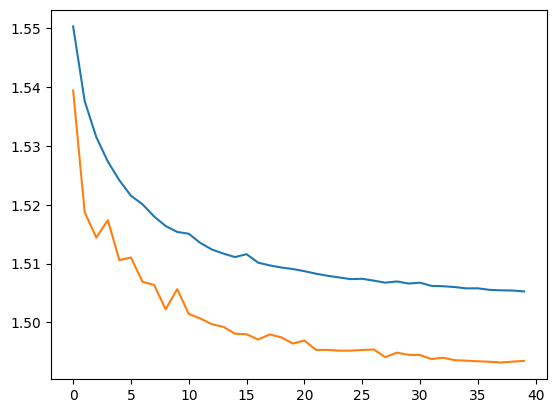

In [12]:
trainer.draw_history_plots()

In [13]:
model.eval()
model.to('cpu')
for X_val, _ in val_dataloader:
  reconstructed = model(X_val)
  img = transforms.ToPILImage()(reconstructed[0]/2+0.5)
  cl = transforms.ToPILImage()(X_val[0])
  cl.show()
  img.show()
  break